In [7]:
# Hyperparameters
learning_rate = 0.01          # Learning rate for the optimizer
discount_rate = 0.99          # Discount rate for future rewards
initial_epsilon = 1.0         # Initial value of epsilon for epsilon-greedy policy
epsilon_decay = 0.995         # Decay rate of epsilon per episode
minimum_epsilon = 0.01        # Minimum value of epsilon to maintain some exploration
total_episodes = 200          # Total number of episodes to train
maximum_steps_per_episode = 100  # Maximum steps per episode to avoid infinite loops
print_table_interval = 30     # Interval after which to print the table

List of Scores:
[-388, -280, -388, -388, -361, -460, -424, -361, -451, -406, -433, -406, -253, -397, -325, -343, -352, -388, -298, -352, -280, -397, -352, -433, -379, -379, -388, -433, -424, -325, -352, -397, -415, -325, -388, -316, -334, -379, -325, -289, -361, -316, -298, -298, -280, -352, -397, -352, -325, -343, -280, -307, -235, -388, -262, -289, -280, -334, -253, -325, -208, -307, -298, -289, -316, -253, -217, -244, -262, -307, -262, -289, -271, -343, -280, -271, -208, -271, -316, -289, -244, -280, -379, -370, -244, -298, -325, -298, -217, -253, -271, -289, -325, -244, -289, -289, -226, -262, -289, -253, -244, -289, -262, -298, -172, -102, -289, -271, -280, -262, -262, -199, -244, -244, -183, -244, -65, -262, -208, -271, -289, -253, -298, -253, -208, -262, -111, -271, -271, -154, -226, -226, -325, -262, -244, -235, -271, -307, -244, -172, -208, -253, -217, -199, -217, -190, -307, -235, -325, -217, -253, -235, -226, -226, -154, -244, -226, -280, -208, -217, -172, -226, -190, -172, 

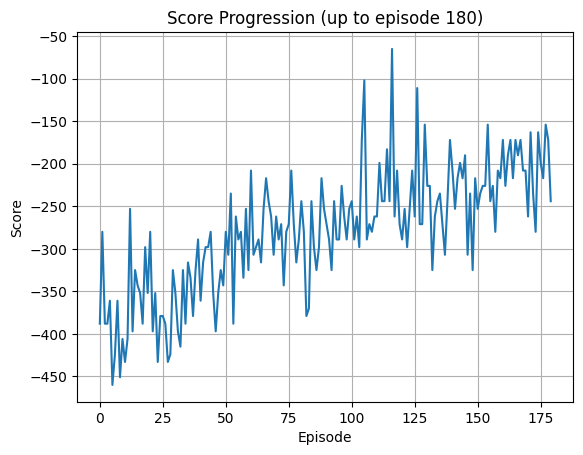

In [8]:
import subprocess
import sys
import os

# Function to install necessary Python packages
def install_package(package_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# List of required packages
required_packages = ['gymnasium', 'numpy', 'torch', 'matplotlib', 'pandas', 'fpdf']

# Ensure necessary packages are installed
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        install_package(package)

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import functools
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from matplotlib.backends.backend_pdf import PdfPages

# Create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# Define the neural network class
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create Taxi environment
taxi_environment = gym.make('Taxi-v3')
taxi_environment.reset(seed=123)
state_size = taxi_environment.observation_space.n
action_size = taxi_environment.action_space.n

# Function to convert state tuple to integer
def convert_tuple_to_int(state_tuple) -> int:
    if isinstance(state_tuple, tuple):
        if isinstance(state_tuple[-1], dict):
            return functools.reduce(lambda sub, ele: sub * 10 + ele, state_tuple[:-1])
        else:
            return functools.reduce(lambda sub, ele: sub * 10 + ele, state_tuple)
    else:
        return state_tuple

# Initialize neural network
q_network = QNetwork(state_size, action_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(q_network.parameters(), lr=0.01)

# List to track the scores during training
episode_scores = []

# Prepare PDF file for output
pdf_file = PdfPages('results/deep_learning_plots.pdf')

# Training process
epsilon = initial_epsilon
plt.ion()
figure, axis = plt.subplots()
for episode in range(total_episodes):
    state = taxi_environment.reset(seed=123)
    state = convert_tuple_to_int(state)  # Convert state tuple to integer
    total_reward = 0
    episode_done = False
    for _ in range(maximum_steps_per_episode):
        # Convert state to one-hot encoded vector
        state_one_hot = np.eye(state_size)[state]
        state_one_hot = torch.FloatTensor(state_one_hot).unsqueeze(0)

        # Exploration-exploitation tradeoff
        if random.uniform(0, 1) < epsilon:
            action = taxi_environment.action_space.sample()  # Explore
        else:
            with torch.no_grad():
                q_values = q_network(state_one_hot)
            action = np.argmax(q_values.cpu().numpy())  # Exploit

        new_state, reward, episode_done, _, _ = taxi_environment.step(action)
        new_state = convert_tuple_to_int(new_state)  # Convert new_state tuple to integer
        total_reward += reward

        # Q-learning algorithm
        with torch.no_grad():
            new_state_one_hot = torch.FloatTensor(np.eye(state_size)[new_state]).unsqueeze(0)
            new_q_values = q_network(new_state_one_hot)
            max_new_q_value = torch.max(new_q_values)
        target_q = reward + discount_rate * max_new_q_value
        predicted_q = q_network(state_one_hot).squeeze()[action]

        loss = criterion(predicted_q, target_q.clone().detach().float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = new_state

        if episode_done:
            break
    
    # Decay epsilon
    epsilon = max(minimum_epsilon, epsilon * epsilon_decay)

    # Add the total reward of the episode to the scores list
    episode_scores.append(total_reward)

    if (episode + 1) % print_table_interval == 0:
        # Display the scores as a table
        scores_dataframe = pd.DataFrame(episode_scores, columns=["Score"])
        display(scores_dataframe.tail(10))  # Display the last 10 scores for inspection

        # Plot scores up to the current episode
        axis.clear()
        axis.plot(episode_scores)
        axis.set_xlabel('Episode')
        axis.set_ylabel('Score')
        axis.set_title(f'Score Progression (up to episode {episode + 1})')
        axis.grid(True)
        
        # Save plot to PDF
        pdf_file.savefig(figure)
        
        clear_output(wait=True)

plt.ioff()
pdf_file.close()

# Print the list of scores
print("List of Scores:")
print(episode_scores)

# Close the environment
taxi_environment.close()